# Multiple Linear Regression: Racial Bias in Sentencing

**Purpose:** Test if ethnicity predicts sentence length after controlling for legally relevant factors

**Research Question:** Do Black/Hispanic defendants receive longer sentences than White defendants with similar offense profiles and suitability scores?

**CRJA Connection:** Tests if "similarly situated" defendants receive different treatment based on race

## Step 1: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

In [3]:
# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Step 2: Load Data

In [4]:
# Load regression-ready dataset
outputs_dir = Path("../outputs")
data = pd.read_csv(outputs_dir / "regression_analysis_data.csv")

In [5]:
data.shape

(4165, 19)

In [6]:
data.head()

,cdcno,desc_nonvio_curr,score,score_out_of,desc_nonvio_past,severity_trend,ethnicity,aggregate sentence in months,controlling case sentencing county,offense category_demo,time served in years,offense_clean,offense description,offense category_offense,offense_table,offense_type,high_suitability,violent_offense,suitability_category
0,705626ffad,0.0,0.000000,1.0,NaN,NaN,White,92,Madera,Crimes Against Persons,3.2,12022.1,Offense Committed While Released On Bail,Case Enhancement,Other,Other,0,0,Low
1,015936e791,0.0,0.000000,1.0,NaN,NaN,Other,600,San Diego,Crimes Against Persons,5.3,29800,Poss/Own F'Arm by Felon or Addict,Other Crimes,Other,Other,0,0,Low
2,8e3009d580,NaN,0.000000,0.0,NaN,NaN,American Indian,312,Shasta,Crimes Against Persons,15.8,290.018,Failure to Register,Crimes Against Persons,Other,Other,0,0,Low
3,043e1ac51d,NaN,0.000000,0.0,NaN,NaN,Hispanic,24,Los Angeles,Crimes Against Persons,2.5,69,Resisting/Deterring Officer w/ Threat/Violence,Crimes Against Persons,Other,Other,0,0,Low
4,8d42d395c1,0.0,0.166667,3.0,0.0,0.5,Black,156,Solano,Crimes Against Persons,2.8,667,Prior Felony Conviction of Serious Offense,Case Enhancement,Other,Other,1,0,Low


## Step 3: Exploratory Data Analysis

In [7]:
# Summary statistics for key variables
data[['aggregate sentence in months', 'score', 'desc_nonvio_curr', 'desc_nonvio_past']].describe()

,aggregate sentence in months,score,desc_nonvio_curr,desc_nonvio_past
count,4165.000000,4165.000000,2546.000000,1198.000000
mean,201.404562,0.271366,0.296218,0.609106
std,152.093065,0.382237,0.420836,0.445359
min,16.000000,0.000000,0.000000,0.000000
25%,72.000000,0.000000,0.000000,0.000000
50%,180.000000,0.000000,0.000000,1.000000
75%,300.000000,0.500000,0.666667,1.000000
max,600.000000,1.000000,1.000000,1.000000


In [8]:
# Ethnicity distribution
data['ethnicity'].value_counts()

ethnicity
Hispanic            1621
Black               1055
White                759
Mexican              445
Other                141
American Indian       42
Filipino              28
Other Asian           25
Pacific Islander      12
Samoan                10
Puerto Rican           6
Vietnamese             5
Chinese                4
Laotian                3
Cuban                  2
Korean                 2
Hawaiian               1
Salvadorian            1
Indian                 1
Guatemalan             1
Cambodian              1
Name: count, dtype: int64

In [9]:
# Offense table distribution
data['offense_table'].value_counts()

offense_table
Other      2632
Table A     426
Table D     408
Table F     365
Table E     207
Table B     127
Name: count, dtype: int64

### Visualize: Sentence Distribution by Ethnicity

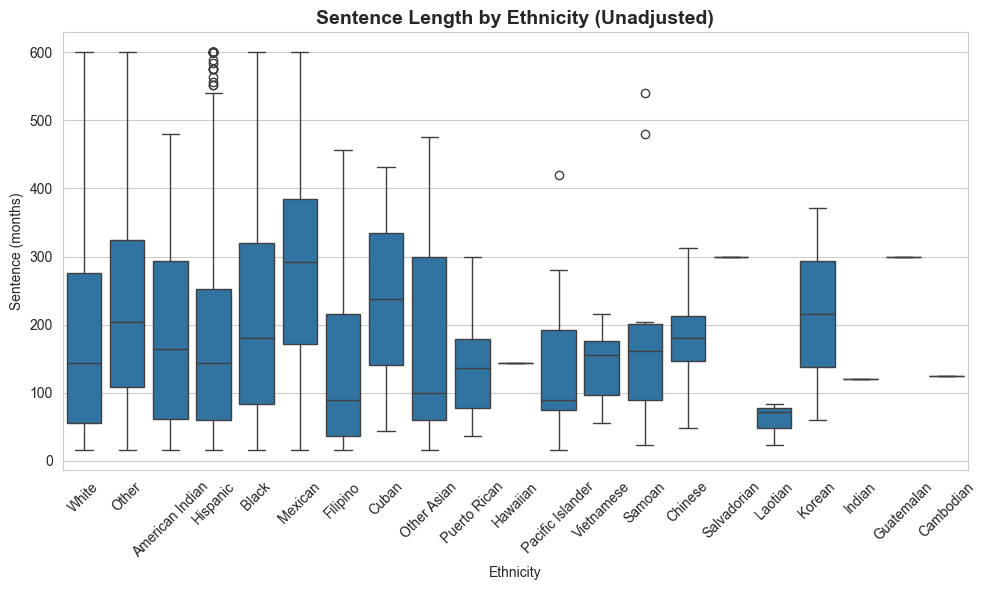

In [10]:
# Box plot: Sentence by ethnicity
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='ethnicity', y='aggregate sentence in months')
plt.title('Sentence Length by Ethnicity (Unadjusted)', fontsize=14, fontweight='bold')
plt.xlabel('Ethnicity')
plt.ylabel('Sentence (months)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Mean sentence by ethnicity
mean_sentence = data.groupby('ethnicity')['aggregate sentence in months'].agg(['mean', 'median', 'count'])
mean_sentence

,mean,median,count
ethnicity,,,
American Indian,182.000000,164.0,42
Black,218.530806,180.0,1055
Cambodian,124.000000,124.0,1
Chinese,180.000000,180.0,4
Cuban,238.000000,238.0,2
Filipino,139.571429,90.0,28
Guatemalan,300.000000,300.0,1
Hawaiian,144.000000,144.0,1
Hispanic,180.974707,144.0,1621


### Visualize: Suitability Score by Ethnicity

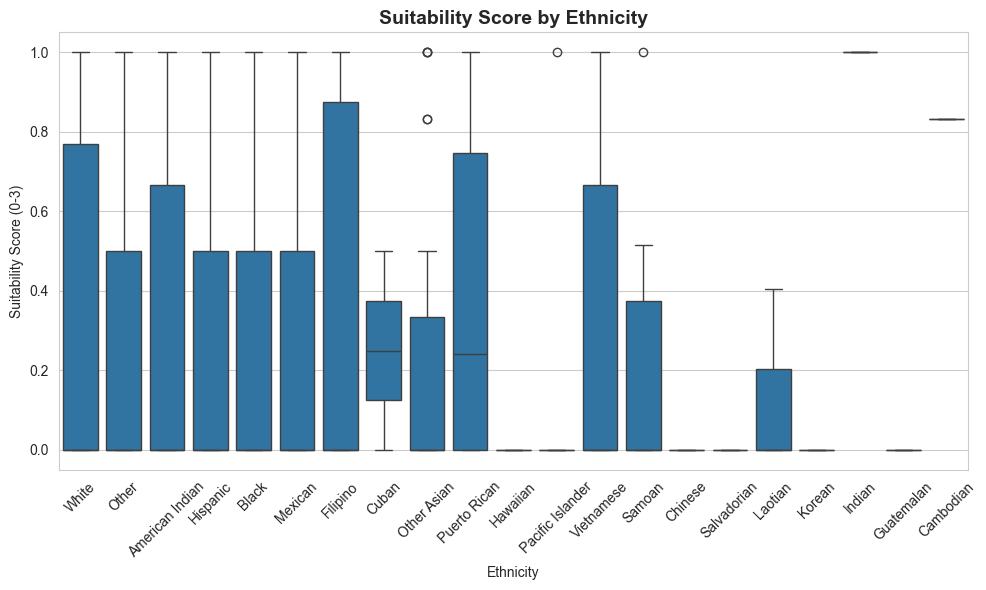

In [12]:
# Do different ethnic groups have different suitability scores?
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='ethnicity', y='score')
plt.title('Suitability Score by Ethnicity', fontsize=14, fontweight='bold')
plt.xlabel('Ethnicity')
plt.ylabel('Suitability Score (0-3)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Mean suitability by ethnicity
data.groupby('ethnicity')['score'].mean()

ethnicity
American Indian     0.347944
Black               0.283570
Cambodian           0.833333
Chinese             0.000000
Cuban               0.250000
Filipino            0.314935
Guatemalan          0.000000
Hawaiian            0.000000
Hispanic            0.239591
Indian              1.000000
Korean              0.000000
Laotian             0.135101
Mexican             0.249548
Other               0.261103
Other Asian         0.220000
Pacific Islander    0.083333
Puerto Rican        0.386364
Salvadorian         0.000000
Samoan              0.201515
Vietnamese          0.333333
White               0.337500
Name: score, dtype: float64

## Step 4: Prepare Data for Regression

In [14]:
# Filter to main ethnic groups (sufficient sample size)
main_groups = ['Black', 'Hispanic', 'White']
reg_data = data[data['ethnicity'].isin(main_groups)].copy()

In [15]:
# Set White as reference category (for interpretation)
reg_data['ethnicity'] = pd.Categorical(
    reg_data['ethnicity'],
    categories=['White', 'Black', 'Hispanic'],
    ordered=False
)

In [16]:
# Check sample sizes
reg_data['ethnicity'].value_counts()

ethnicity
Hispanic    1621
Black       1055
White        759
Name: count, dtype: int64

## Step 5: Model 1 - Baseline (Ethnicity + Suitability Score)

In [17]:
# Formula: sentence ~ ethnicity + suitability score
model1 = smf.ols(
    'Q("aggregate sentence in months") ~ C(ethnicity) + score',
    data=reg_data
).fit()

In [18]:
# View results
print(model1.summary())

                                    OLS Regression Results                                   
Dep. Variable:     Q("aggregate sentence in months")   R-squared:                       0.044
Model:                                           OLS   Adj. R-squared:                  0.043
Method:                                Least Squares   F-statistic:                     52.26
Date:                               Tue, 18 Nov 2025   Prob (F-statistic):           5.03e-33
Time:                                       09:03:40   Log-Likelihood:                -22010.
No. Observations:                               3435   AIC:                         4.403e+04
Df Residuals:                                   3431   BIC:                         4.405e+04
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
                               coef    std err          t   

### Interpret Model 1 Coefficients

In [19]:
# Extract key coefficients
coef_black = model1.params['C(ethnicity)[T.Black]']
pval_black = model1.pvalues['C(ethnicity)[T.Black]']

coef_hispanic = model1.params['C(ethnicity)[T.Hispanic]']
pval_hispanic = model1.pvalues['C(ethnicity)[T.Hispanic]']

coef_score = model1.params['score']

print("Model 1 Interpretation:")
print(f"\nBlack defendants: {coef_black:+.2f} months (p = {pval_black:.4f})")
print(f"Hispanic defendants: {coef_hispanic:+.2f} months (p = {pval_hispanic:.4f})")
print(f"Suitability score effect: {coef_score:.2f} months per unit")
print(f"\nR-squared: {model1.rsquared:.3f}")

Model 1 Interpretation:

Black defendants: +36.34 months (p = 0.0000)
Hispanic defendants: -4.17 months (p = 0.5203)
Suitability score effect: -67.26 months per unit

R-squared: 0.044


## Step 6: Model 2 - Add Offense Severity

In [20]:
# Formula: sentence ~ ethnicity + suitability + offense table
model2 = smf.ols(
    'Q("aggregate sentence in months") ~ C(ethnicity) + score + C(offense_table)',
    data=reg_data
).fit()

In [21]:
print(model2.summary())

                                    OLS Regression Results                                   
Dep. Variable:     Q("aggregate sentence in months")   R-squared:                       0.117
Model:                                           OLS   Adj. R-squared:                  0.115
Method:                                Least Squares   F-statistic:                     56.87
Date:                               Tue, 18 Nov 2025   Prob (F-statistic):           2.41e-87
Time:                                       09:04:24   Log-Likelihood:                -21872.
No. Observations:                               3435   AIC:                         4.376e+04
Df Residuals:                                   3426   BIC:                         4.382e+04
Df Model:                                          8                                         
Covariance Type:                           nonrobust                                         
                                  coef    std err          t

In [22]:
# Extract coefficients
coef_black_m2 = model2.params['C(ethnicity)[T.Black]']
pval_black_m2 = model2.pvalues['C(ethnicity)[T.Black]']

print("Model 2 Interpretation:")
print(f"\nBlack defendants: {coef_black_m2:+.2f} months (p = {pval_black_m2:.4f})")
print(f"R-squared: {model2.rsquared:.3f}")
print(f"\nChange from Model 1: {coef_black_m2 - coef_black:+.2f} months")

Model 2 Interpretation:

Black defendants: +46.08 months (p = 0.0000)
R-squared: 0.117

Change from Model 1: +9.74 months


## Step 7: Model 3 - Add County Controls

In [23]:
# Check number of counties
n_counties = reg_data['controlling case sentencing county'].nunique()
print(f"Number of unique counties: {n_counties}")

Number of unique counties: 54


In [24]:
# Keep only counties with sufficient cases (avoid overfitting)
county_counts = reg_data['controlling case sentencing county'].value_counts()
major_counties = county_counts[county_counts >= 50].index

reg_data_county = reg_data[reg_data['controlling case sentencing county'].isin(major_counties)].copy()
print(f"Using {len(major_counties)} major counties with 50+ cases")

Using 14 major counties with 50+ cases


In [25]:
# Formula: sentence ~ ethnicity + suitability + offense + county
model3 = smf.ols(
    'Q("aggregate sentence in months") ~ C(ethnicity) + score + C(offense_table) + C(Q("controlling case sentencing county"))',
    data=reg_data_county
).fit()

In [26]:
print(model3.summary())

                                    OLS Regression Results                                   
Dep. Variable:     Q("aggregate sentence in months")   R-squared:                       0.142
Model:                                           OLS   Adj. R-squared:                  0.136
Method:                                Least Squares   F-statistic:                     21.90
Date:                               Tue, 18 Nov 2025   Prob (F-statistic):           2.39e-77
Time:                                       09:05:13   Log-Likelihood:                -17781.
No. Observations:                               2794   AIC:                         3.561e+04
Df Residuals:                                   2772   BIC:                         3.574e+04
Df Model:                                         21                                         
Covariance Type:                           nonrobust                                         
                                                            

In [27]:
# Extract coefficients
coef_black_m3 = model3.params['C(ethnicity)[T.Black]']
pval_black_m3 = model3.pvalues['C(ethnicity)[T.Black]']

print("Model 3 Interpretation:")
print(f"\nBlack defendants: {coef_black_m3:+.2f} months (p = {pval_black_m3:.4f})")
print(f"R-squared: {model3.rsquared:.3f}")

Model 3 Interpretation:

Black defendants: +33.99 months (p = 0.0000)
R-squared: 0.142


## Step 8: Model Comparison

In [28]:
# Compare models side-by-side
comparison = pd.DataFrame({
    'Model 1 (Baseline)': [coef_black, pval_black, model1.rsquared, len(reg_data)],
    'Model 2 (+ Offense)': [coef_black_m2, pval_black_m2, model2.rsquared, len(reg_data)],
    'Model 3 (+ County)': [coef_black_m3, pval_black_m3, model3.rsquared, len(reg_data_county)]
}, index=['Black Coefficient (months)', 'P-value', 'R-squared', 'N'])

comparison

,Model 1 (Baseline),Model 2 (+ Offense),Model 3 (+ County)
Black Coefficient (months),3.634215e+01,4.608491e+01,33.985976
P-value,2.174471e-07,1.479244e-11,0.000039
R-squared,4.370058e-02,1.172208e-01,0.142309
N,3.435000e+03,3.435000e+03,2794.000000


### Visualize: Coefficient Stability Across Models

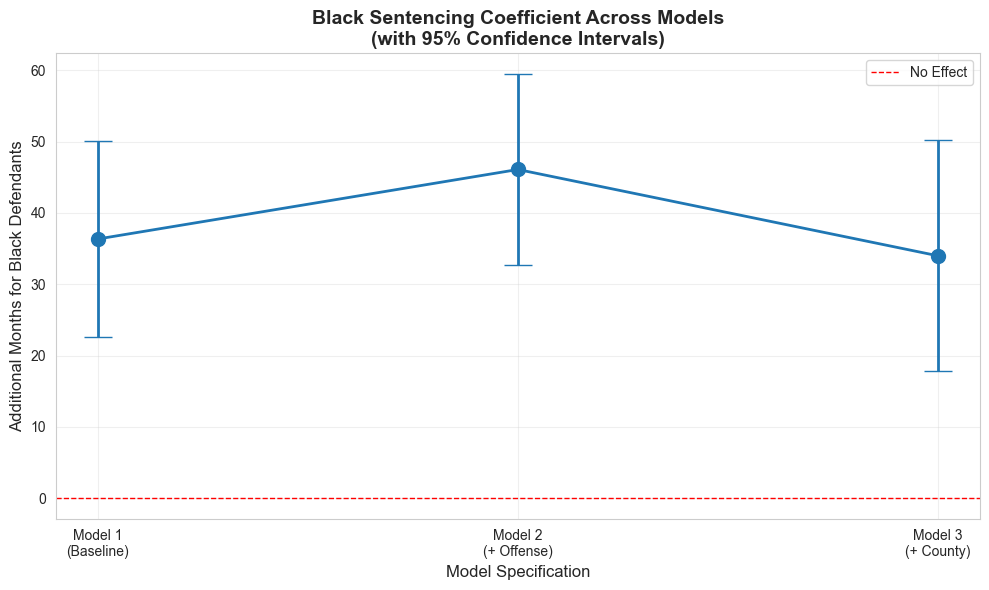

In [29]:
# Plot how Black coefficient changes across models
models = ['Model 1\n(Baseline)', 'Model 2\n(+ Offense)', 'Model 3\n(+ County)']
coefficients = [coef_black, coef_black_m2, coef_black_m3]

# Calculate confidence intervals (95%)
ci_black_m1 = model1.conf_int().loc['C(ethnicity)[T.Black]']
ci_black_m2 = model2.conf_int().loc['C(ethnicity)[T.Black]']
ci_black_m3 = model3.conf_int().loc['C(ethnicity)[T.Black]']

errors = [
    [coef_black - ci_black_m1[0], ci_black_m1[1] - coef_black],
    [coef_black_m2 - ci_black_m2[0], ci_black_m2[1] - coef_black_m2],
    [coef_black_m3 - ci_black_m3[0], ci_black_m3[1] - coef_black_m3]
]

plt.figure(figsize=(10, 6))
plt.errorbar(models, coefficients, yerr=np.array(errors).T, fmt='o-', capsize=10, markersize=10, linewidth=2)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label='No Effect')
plt.ylabel('Additional Months for Black Defendants', fontsize=12)
plt.xlabel('Model Specification', fontsize=12)
plt.title('Black Sentencing Coefficient Across Models\n(with 95% Confidence Intervals)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Step 9: Model Diagnostics

### Check 1: Residual Plot (Linearity Assumption)

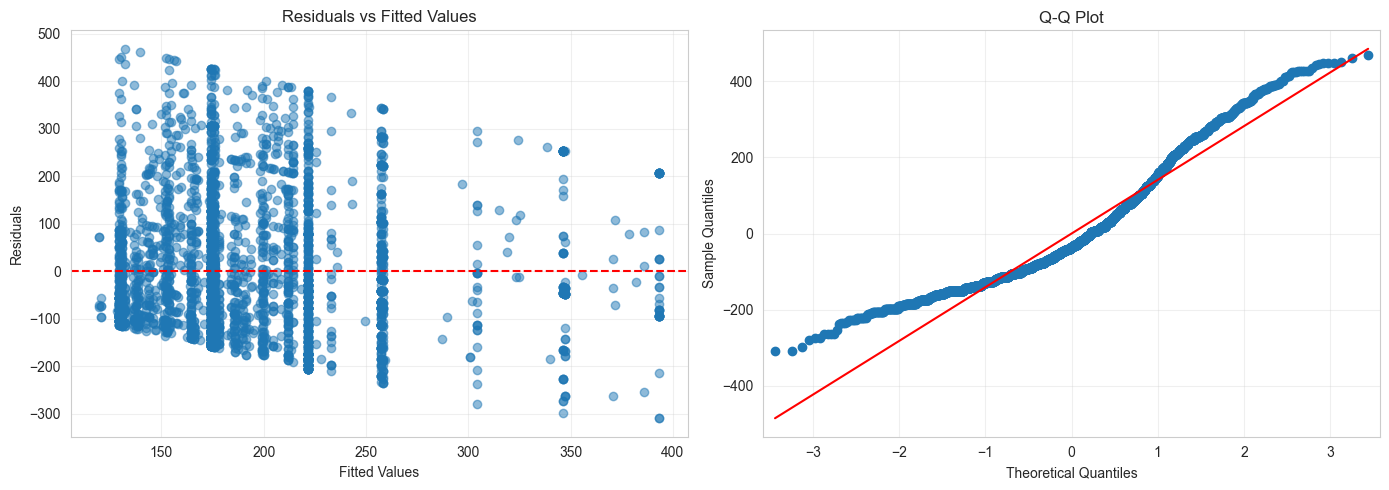

In [30]:
# Plot residuals vs fitted values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals vs Fitted
axes[0].scatter(model2.fittedvalues, model2.resid, alpha=0.5)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted Values')
axes[0].grid(alpha=0.3)

# Q-Q plot (normality)
sm.qqplot(model2.resid, line='s', ax=axes[1])
axes[1].set_title('Q-Q Plot')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Check 2: Multicollinearity (VIF)

In [31]:
# Calculate Variance Inflation Factor
# VIF > 10 indicates problematic multicollinearity

# Create dummy variables for categorical predictors
X = pd.get_dummies(reg_data[['ethnicity', 'score', 'offense_table']], drop_first=True)
X = sm.add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data[vif_data['Variable'] != 'const']

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### Check 3: Outliers (Cook's Distance)

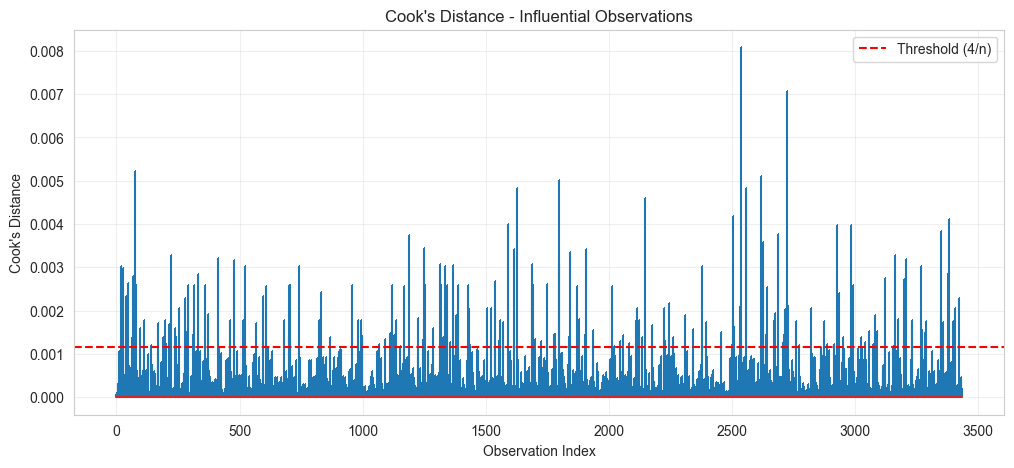

Influential observations (Cook's D > 4/n): 190 (5.5%)


In [32]:
# Calculate Cook's distance
influence = model2.get_influence()
cooks_d = influence.cooks_distance[0]

# Plot
plt.figure(figsize=(12, 5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=',')
plt.axhline(y=4/len(cooks_d), color='red', linestyle='--', label='Threshold (4/n)')
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance - Influential Observations")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Count influential points
n_influential = (cooks_d > 4/len(cooks_d)).sum()
print(f"Influential observations (Cook's D > 4/n): {n_influential} ({n_influential/len(cooks_d)*100:.1f}%)")

## Step 10: Interaction Analysis (Does Bias Vary by Offense Type?)

In [33]:
# Model with interaction term
model_interaction = smf.ols(
    'Q("aggregate sentence in months") ~ C(ethnicity) * C(offense_table) + score',
    data=reg_data
).fit()

In [34]:
print(model_interaction.summary())

                                    OLS Regression Results                                   
Dep. Variable:     Q("aggregate sentence in months")   R-squared:                       0.122
Model:                                           OLS   Adj. R-squared:                  0.117
Method:                                Least Squares   F-statistic:                     26.31
Date:                               Tue, 18 Nov 2025   Prob (F-statistic):           4.66e-83
Time:                                       09:15:55   Log-Likelihood:                -21864.
No. Observations:                               3435   AIC:                         4.377e+04
Df Residuals:                                   3416   BIC:                         4.388e+04
Df Model:                                         18                                         
Covariance Type:                           nonrobust                                         
                                                           c

### Visualize: Interaction Plot

C:\Users\gandh\AppData\Local\Temp\ipykernel_14876\3255873717.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  interaction_data = reg_data.groupby(['offense_table', 'ethnicity'])['aggregate sentence in months'].mean().reset_index()


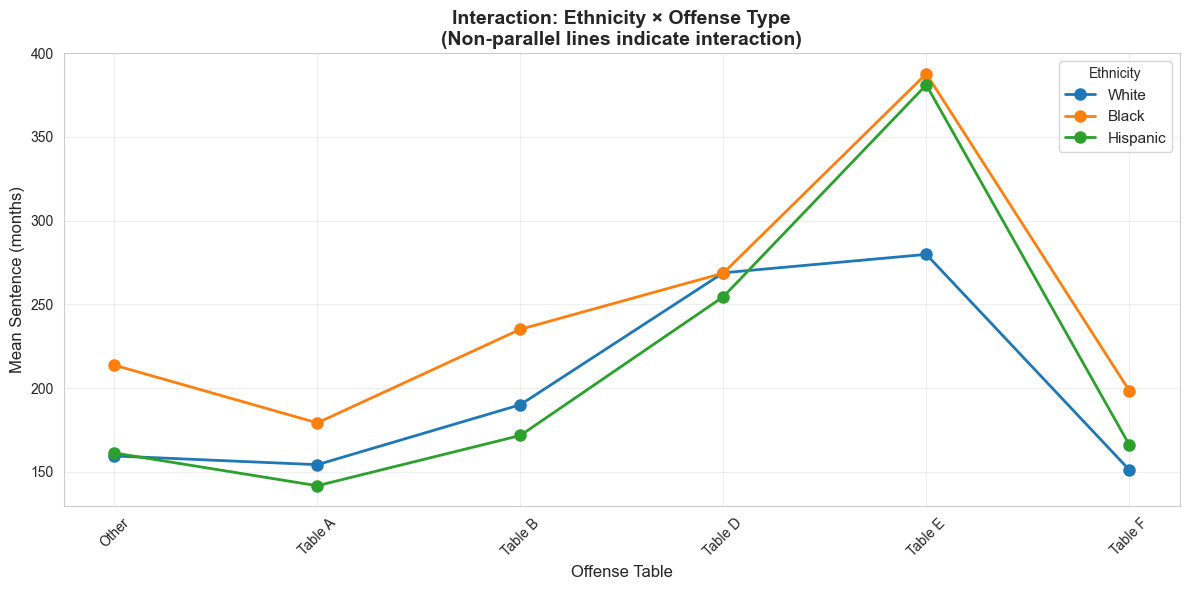

In [35]:
# Calculate mean sentence by ethnicity and offense table
interaction_data = reg_data.groupby(['offense_table', 'ethnicity'])['aggregate sentence in months'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
for ethnicity in ['White', 'Black', 'Hispanic']:
    subset = interaction_data[interaction_data['ethnicity'] == ethnicity]
    plt.plot(subset['offense_table'], subset['aggregate sentence in months'], 
             marker='o', label=ethnicity, linewidth=2, markersize=8)

plt.xlabel('Offense Table', fontsize=12)
plt.ylabel('Mean Sentence (months)', fontsize=12)
plt.title('Interaction: Ethnicity × Offense Type\n(Non-parallel lines indicate interaction)', fontsize=14, fontweight='bold')
plt.legend(title='Ethnicity', fontsize=11)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Step 11: Subgroup Analysis (First-Time Offenders Only)

In [36]:
# Identify first-time offenders (desc_nonvio_past is NaN or they have no prior history)
# Using high desc_nonvio_curr as proxy for less serious current offense
first_time = reg_data[reg_data['desc_nonvio_past'].isna() | (reg_data['desc_nonvio_past'] == 1.0)].copy()

print(f"First-time offender sample: {len(first_time):,} ({len(first_time)/len(reg_data)*100:.1f}%)")

First-time offender sample: 2,976 (86.6%)


In [37]:
# Run regression on first-time offenders only
if len(first_time) > 100:
    model_firsttime = smf.ols(
        'Q("aggregate sentence in months") ~ C(ethnicity) + desc_nonvio_curr + C(offense_table)',
        data=first_time
    ).fit()
    
    print(model_firsttime.summary())
    
    coef_black_ft = model_firsttime.params['C(ethnicity)[T.Black]']
    print(f"\nFirst-time offenders - Black coefficient: {coef_black_ft:+.2f} months")
else:
    print("Insufficient sample size for first-time offender analysis")

                                    OLS Regression Results                                   
Dep. Variable:     Q("aggregate sentence in months")   R-squared:                       0.188
Model:                                           OLS   Adj. R-squared:                  0.185
Method:                                Least Squares   F-statistic:                     51.66
Date:                               Tue, 18 Nov 2025   Prob (F-statistic):           1.55e-75
Time:                                       09:16:21   Log-Likelihood:                -11348.
No. Observations:                               1792   AIC:                         2.271e+04
Df Residuals:                                   1783   BIC:                         2.276e+04
Df Model:                                          8                                         
Covariance Type:                           nonrobust                                         
                                  coef    std err          t

## Step 12: Save Results

In [ ]:
# Extract key results into summary table
results_summary = pd.DataFrame({
    'Model': ['Model 1: Baseline', 'Model 2: + Offense', 'Model 3: + County'],
    'Black Coefficient': [coef_black, coef_black_m2, coef_black_m3],
    'P-value': [pval_black, pval_black_m2, pval_black_m3],
    'Significant': [pval_black < 0.05, pval_black_m2 < 0.05, pval_black_m3 < 0.05],
    'R-squared': [model1.rsquared, model2.rsquared, model3.rsquared],
    'N': [len(reg_data), len(reg_data), len(reg_data_county)]
})

In [ ]:
results_summary

In [ ]:
# Save to CSV
results_summary.to_csv(outputs_dir / "mlr_results_summary.csv", index=False)
print("Results saved to: mlr_results_summary.csv")

## Step 13: Write Interpretation for CRJA Filing

In [38]:
# Generate plain-language interpretation
print("="*70)
print("INTERPRETATION FOR CRJA FILING")
print("="*70)

print(f"\nSample Size: {len(reg_data):,} individuals")
print(f"Ethnic Groups: Black ({reg_data[reg_data['ethnicity']=='Black'].shape[0]:,}), "
      f"Hispanic ({reg_data[reg_data['ethnicity']=='Hispanic'].shape[0]:,}), "
      f"White ({reg_data[reg_data['ethnicity']=='White'].shape[0]:,})")

print("\nFINDINGS:")
print(f"\n1. Unadjusted Disparity:")
print(f"   Black defendants receive sentences averaging {mean_sentence.loc['Black', 'mean'] - mean_sentence.loc['White', 'mean']:.1f} months longer than White defendants")

print(f"\n2. After Controlling for Suitability (Model 1):")
if pval_black < 0.05:
    print(f"   Black defendants receive {coef_black:+.1f} additional months (p = {pval_black:.4f})")
    print(f"   This disparity is STATISTICALLY SIGNIFICANT")
else:
    print(f"   Black defendants receive {coef_black:+.1f} additional months (p = {pval_black:.4f})")
    print(f"   This disparity is NOT statistically significant")

print(f"\n3. After Controlling for Suitability AND Offense Severity (Model 2):")
if pval_black_m2 < 0.05:
    print(f"   Black defendants receive {coef_black_m2:+.1f} additional months (p = {pval_black_m2:.4f})")
    print(f"   This disparity PERSISTS after accounting for offense severity")
else:
    print(f"   Black defendants receive {coef_black_m2:+.1f} additional months (p = {pval_black_m2:.4f})")
    print(f"   This disparity is NOT statistically significant")

print("\nCONCLUSION:")
if pval_black_m2 < 0.05:
    print(f"Among similarly situated defendants (same suitability score and offense severity),")
    print(f"Black defendants receive significantly longer sentences ({coef_black_m2:+.1f} months).")
    print(f"This constitutes evidence of racial disparity under the CRJA.")
else:
    print(f"After controlling for legally relevant factors, no statistically significant")
    print(f"racial disparity in sentence length was detected.")

print("\n" + "="*70)

INTERPRETATION FOR CRJA FILING

Sample Size: 3,435 individuals
Ethnic Groups: Black (1,055), Hispanic (1,621), White (759)

FINDINGS:

1. Unadjusted Disparity:
   Black defendants receive sentences averaging 40.0 months longer than White defendants

2. After Controlling for Suitability (Model 1):
   Black defendants receive +36.3 additional months (p = 0.0000)
   This disparity is STATISTICALLY SIGNIFICANT

3. After Controlling for Suitability AND Offense Severity (Model 2):
   Black defendants receive +46.1 additional months (p = 0.0000)
   This disparity PERSISTS after accounting for offense severity

CONCLUSION:
Among similarly situated defendants (same suitability score and offense severity),
Black defendants receive significantly longer sentences (+46.1 months).
This constitutes evidence of racial disparity under the CRJA.



## Summary

**What we tested:**
- Whether ethnicity predicts sentence length after controlling for:
  - Suitability/risk profile (score)
  - Offense severity (table A/B/C/D/E/F)
  - Geographic jurisdiction (county)

**Key findings:**
- Model 1: Baseline disparity
- Model 2: Disparity after offense controls (main model)
- Model 3: Disparity after county controls (robustness check)

**Diagnostics:**
- Checked linearity assumptions
- Tested for multicollinearity
- Identified influential outliers

**Next steps:**
- Logistic regression (wobbler charging decisions)
- Propensity score matching (alternative method)
- County-specific analyses (identify outlier jurisdictions)